In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from plot_keras_history import show_history, plot_history

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from keras.layers import Dense, Input, Dropout
import tensorflow_addons as tfa
from keras.regularizers import L1L2
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold

In [3]:
%store -r final_df
final_df

,Temp,Humidity,Wind,Rain,ISI,Actual Fire
0,8.2,51.0,6.7,0.0,5.1,0.0
1,18.0,33.0,0.9,0.0,6.7,0.0
2,14.6,33.0,1.3,0.0,6.7,0.0
3,8.3,97.0,4.0,0.2,9.0,0.0
4,11.4,99.0,1.8,0.0,9.6,0.0
...,...,...,...,...,...,...
756,30.0,65.0,14.0,0.0,4.5,1.0
757,28.0,87.0,15.0,4.4,0.1,0.0
758,27.0,87.0,29.0,0.5,0.4,0.0
759,24.0,54.0,18.0,0.1,1.7,0.0


In [4]:
final_df_remove_outliers = final_df[(np.abs(zscore(final_df)) < 3).all(axis=1)]

final_df.index.difference(final_df_remove_outliers.index)

Int64Index([ 11,  22, 266, 499, 519, 608, 609, 610, 621, 622, 633, 640, 655,
            656, 657, 676, 735, 736, 757, 758],
           dtype='int64')

In [5]:
x = final_df_remove_outliers.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
final_df_scaled = pd.DataFrame(x_scaled)
# final_df_remove_outliers = final_df_remove_outliers / final_df_remove_outliers.max()

In [6]:
classification_x = final_df_scaled.iloc[:,: -2].values
classification_y = final_df_scaled.iloc[:,-1 :].values
print(classification_x.shape,classification_y.shape)

(740, 4) (740, 1)


In [7]:
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(classification_x,classification_y, test_size=0.25, random_state=0)

In [12]:
inputs = Input(shape=(4,))
layer_class = Dense(32,kernel_regularizer=L1L2(l1=0.2, l2=0.2),activation='sigmoid',name='layer1')(inputs)
layer_class = Dropout(0.1)(layer_class)
layer_class = Dense(8, kernel_regularizer=L1L2(l1=0.2, l2=0.2),activation='sigmoid',name='layer2')(layer_class)
layer_class = Dense(4, kernel_regularizer=L1L2(l1=0.2, l2=0.2),activation='sigmoid',name='layer3')(layer_class)
layer_class = Dropout(0.1)(layer_class)
output_class = Dense(1, activation='sigmoid',name='classification')(inputs)

c_model = Model(inputs=inputs, outputs=output_class,name="single_model")

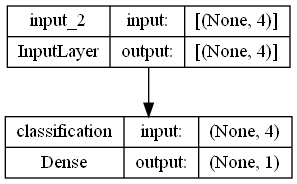

In [13]:
keras.utils.plot_model(c_model, "single_model.png", show_shapes=True)

In [14]:
from keras import metrics
c_model.compile(
    loss=['binary_crossentropy'],
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    metrics=['accuracy']
)

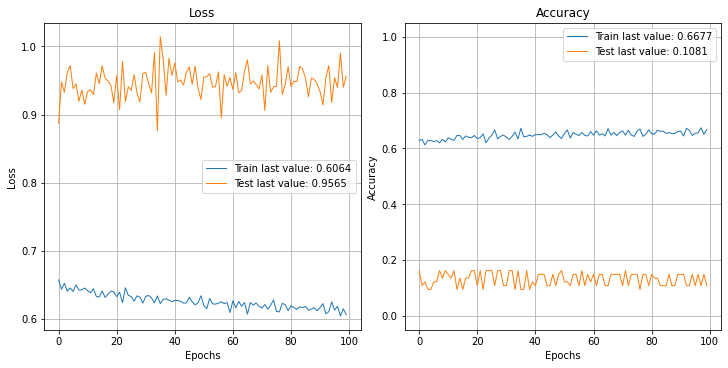

3/3 [==============================] - 0s 1ms/step - loss: 0.9565 - accuracy: 0.1081


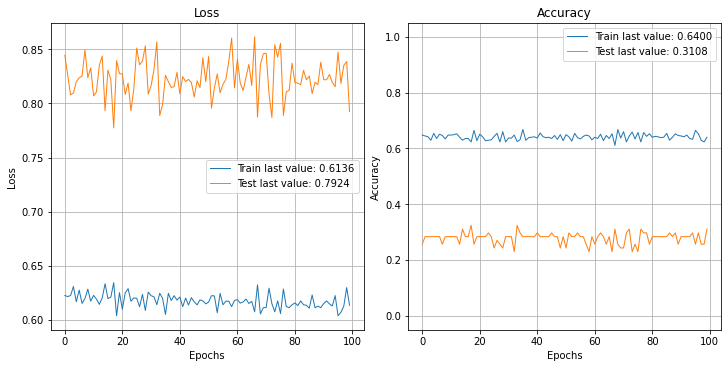

3/3 [==============================] - 0s 1ms/step - loss: 0.7924 - accuracy: 0.3108


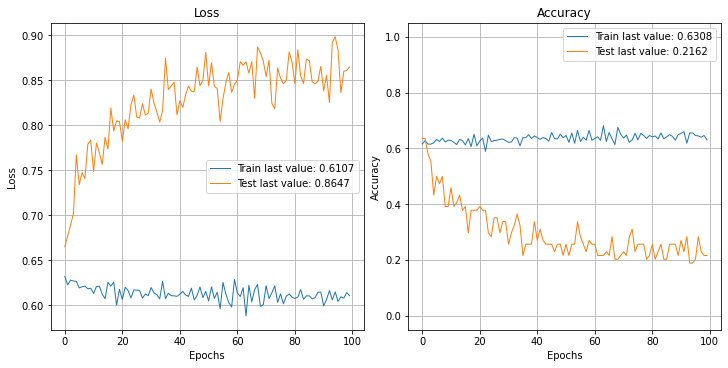

3/3 [==============================] - 0s 1ms/step - loss: 0.8647 - accuracy: 0.2162


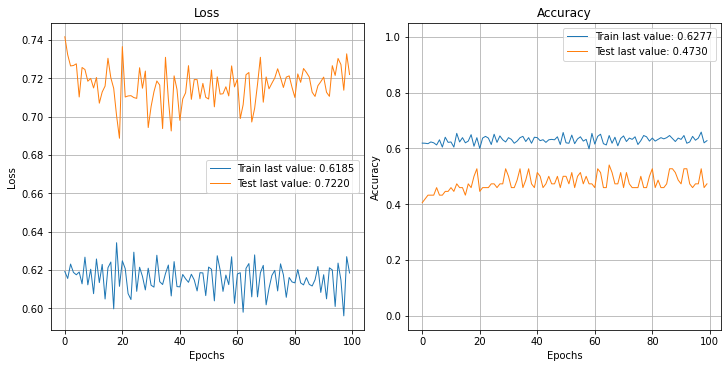

3/3 [==============================] - 0s 1ms/step - loss: 0.7220 - accuracy: 0.4730


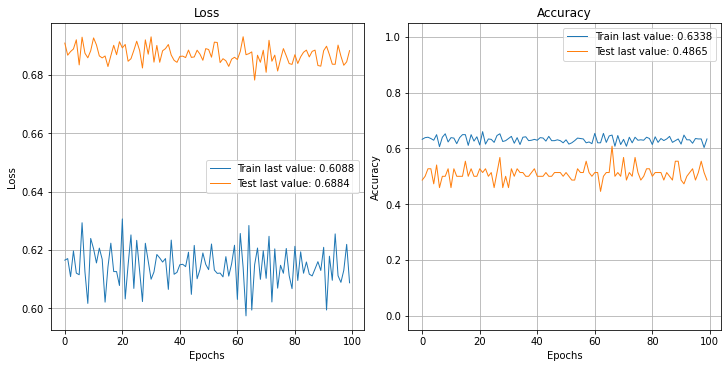

3/3 [==============================] - 0s 1ms/step - loss: 0.6884 - accuracy: 0.4865


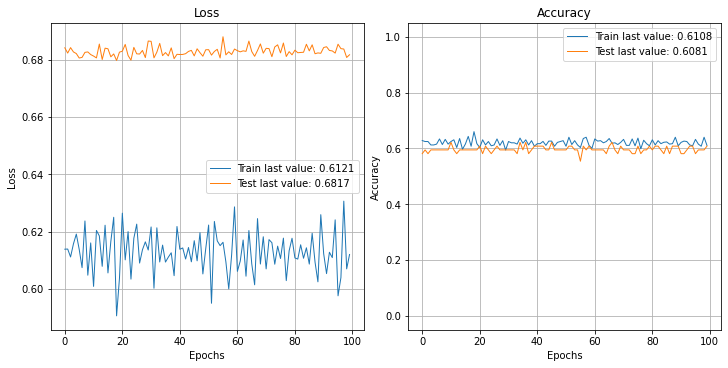

3/3 [==============================] - 0s 1ms/step - loss: 0.6817 - accuracy: 0.6081


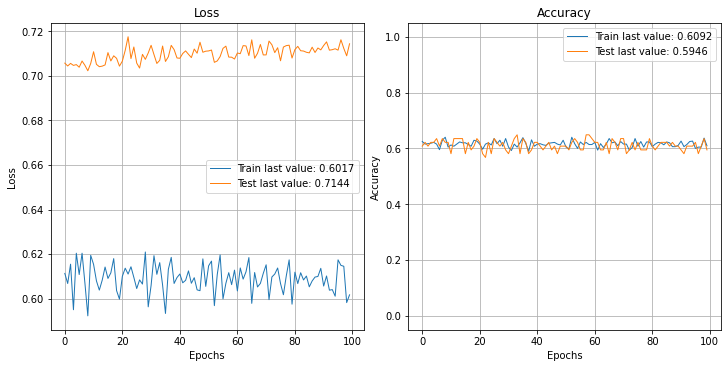

3/3 [==============================] - 0s 1ms/step - loss: 0.7144 - accuracy: 0.5946


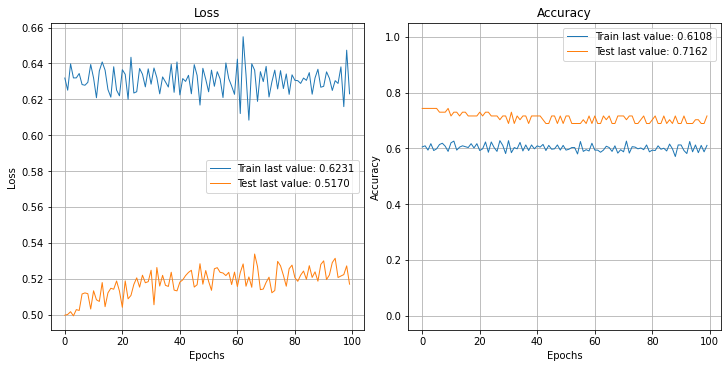

3/3 [==============================] - 0s 1ms/step - loss: 0.5170 - accuracy: 0.7162


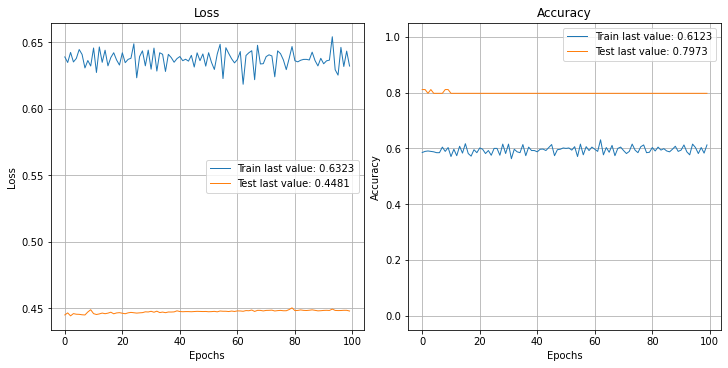

3/3 [==============================] - 0s 500us/step - loss: 0.4481 - accuracy: 0.7973


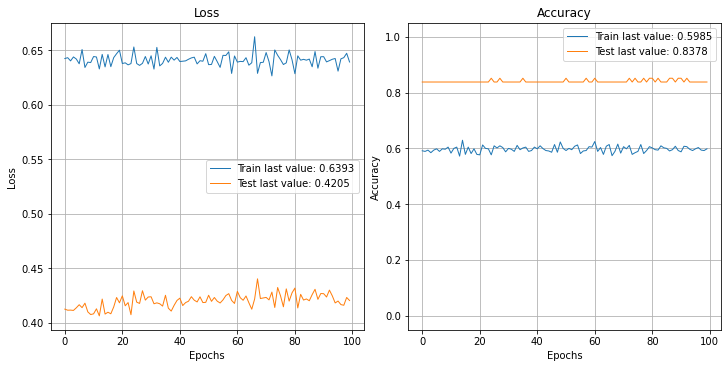

3/3 [==============================] - 0s 1ms/step - loss: 0.4205 - accuracy: 0.8378


In [15]:
from sklearn.model_selection import KFold
n_split=10

for train_index,test_index in KFold(n_split).split(classification_x):
    X_train,X_test=classification_x[train_index],classification_x[test_index]
    y_train,y_test=classification_y[train_index],classification_y[test_index]
  
    model=c_model
    history = model.fit(x=X_train,y=y_train,batch_size=16, verbose=0,shuffle=True, epochs = 100,steps_per_epoch=int(X_train.shape[0]/16),validation_data=(X_test, y_test))
    show_history(history)
    plot_history(history)
    plt.close()
    loss,acc = model.evaluate(X_test,y_test)